- Implementazione in python 

In [96]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import random
from statistics import mean 
import itertools
import ga 

In [97]:
path_file="https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
dataset=pd.read_csv(path_file,parse_dates=['data'])

In [98]:
dataset.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'casi_testati', 'note_it',
       'note_en'],
      dtype='object')

In [99]:
# guariti,infetti,sani, morti 
dataset['asintomatici']= dataset['totale_casi'] * 0.44 
dataset['immuni'] = dataset['dimessi_guariti'] * 0.05  #verificare proporzione
data=dataset[['totale_positivi','dimessi_guariti','deceduti','asintomatici','immuni']]
data

,totale_positivi,dimessi_guariti,deceduti,asintomatici,immuni
0,221,1,7,100.76,0.05
1,311,1,10,141.68,0.05
2,385,3,12,176.00,0.15
3,588,45,17,286.00,2.25
4,821,46,21,390.72,2.30
...,...,...,...,...,...
57,107709,51600,24648,80941.08,2580.00
58,107699,54543,25085,82423.88,2727.15
59,106848,57576,25549,83588.12,2878.80
60,106527,60498,25969,84917.36,3024.90


In [164]:
class Ottimizzazione: 
    def __init__(self):
        pass
    def localsearch(self,massimovaloreiniziale,iterazioni):
        self.massimovaloreiniziale=massimovaloreiniziale
        self.iterazioni=iterazioni
        iniziale = Ott().set_coeff_randomly(0.00001,0.001)
        k=Ott().perturbazione(iniziale)
        k1,k2,k3,k4,k5,k6,k7,k8,k9 =k[0],k[1],k[2],k[3],k[4],k[5],k[6],k[7],k[8]
        errore=100000000000000000000000000000000000000
        val='1'
        for c in range(iterazioni):
            valori=Ott().diffusione()
            stimaerrore=Ott().fitness(valori)
            if stimaerrore<errore:
                errore=stimaerrore
                val=valori
                k1,k2,k3,k4,k5,k6,k7,k8,k9 =k[0],k[1],k[2],k[3],k[4],k[5],k[6],k[7],k[8]
            iniziale = set_coeff_randomly(0,massimovaloreiniziale)  
            k1,k2,k3,k4,k5,k6,k7,k8,k9 =k[0],k[1],k[2],k[3],k[4],k[5],k[6],k[7],k[8]
        return(k,val,errore)


In [174]:
a=Ottimizzazione()
a.localsearch(1,4)

TypeError: deriv() missing 9 required positional arguments: 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', and 'k9'

In [165]:
class Ott:
    def __init__(self):
        self.min_coeff = 0.01
        self.max_coeff = 0.00001
    
    def set_coeff_randomly(self,min,max,n=9):
        return [random.uniform(self.min_coeff,self.max_coeff) for i in range(0,n+1)]
    
    def update_coeff(self,list_values):
        self.list_values=list_values
        diz = {'k1':0,'k2':0,'k3':0,'k4':0,'k5':0,'k6':0,'k7':0,'k8':0,'k9':0}
        for index,coeff in enumerate(diz) : 
            diz[coeff]=list_values[index]
        return diz 
    
    def fitness(self,previsti):
        self.previsti=previsti
        df=pd.DataFrame(self.previsti,columns=['Sani','totale_positivi','dimessi_guariti','deceduti','asintomatici','immuni'])
        df=df.drop(columns=['Sani'])
        dataframe=((df-data)**2)
        lista=dataframe.values.tolist()
        merged = list(itertools.chain.from_iterable(lista))
        media=mean(merged)
        return(media) 
    
    def perturbazione(self,ls):
        self.ls = ls 
        sup = 0.2
        for i in range(len(ls)):
            if ls[i] < 0.5:
                ls[i]=random.uniform(ls[i],ls[i]+sup)
            else:
                ls[i]=random.uniform(0,ls[i]-sup)
        return(ls)
    
    def diffusione(self):
        orizzonte_temporale_in_gg=10
        Sani = 3208
        Infetti=100
        Guariti=0
        Morti= 2
        Immuni = 8
        Asintomatici = 10
        y0 =  [Sani,Infetti,Morti,Guariti,Immuni,Asintomatici]
        t = np.linspace(0,orizzonte_temporale_in_gg,orizzonte_temporale_in_gg)
        ret = odeint(deriv, y0, t)
        return(ret)
    
    def deriv(y,t):  
        '''set di equazioni differenziali'''
        Sani,Infetti,Asintomatici,Morti,Guariti,Immuni = y 
        dSanidt =  -k1*Sani*Infetti -k2*Sani*Infetti-k3*Sani*Asintomatici- k4*Sani*Asintomatici
        dInfettidt = k1*Sani*Infetti+k4*Sani-k6*Infetti-k7*Infetti
        dAsintomaticidt = k2*Sani*Infetti+k3*Sani*Asintomatici-k5*Asintomatici
        dMortidt=k6*Infetti
        dGuaritidt = k5*Asintomatici+k7*Infetti-k8*Guariti-k9*Guariti
        dImmunidt = k9*Guariti
        return dSanidt,dInfettidt,dAsintomaticidt,dMortidt,dGuaritidt,dImmunidt  




In [160]:
a = Ottimizzazione()
a.localsearch(1,4)

TypeError: deriv() missing 9 required positional arguments: 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', and 'k9'

# ILS 

In [107]:
def ils(iterazioni,max_iterazioni,massimovaloreiniziale):
    iniziale = [random.uniform(0,massimovaloreiniziale),random.uniform(0,massimovaloreiniziale),random.uniform(0,massimovaloreiniziale)]
    loc_search = localsearch(massimovaloreiniziale,iterazioni)
    k=loc_search[0]
    best_val = loc_search[1]
    best_errore = loc_search[2]
    #iter_errore = [best_errore]
    #iter_best_errore = [best_errore]
    for c in range(max_iterazioni):
        val=best_val
        nuova_iniziale = perturbazione(k)
        loc_search = localsearch(massimovaloreiniziale,iterazioni)
        val = loc_search[1]
        if loc_search[2] < best_errore: # Se nuovo errore minore best si aggiorna il best
            best_errore = loc_search[2]
            best_val= loc_search[1]
            k=loc_search[0]
       # elif loc_search[0] == best_pers and loc_search[1] < best_num: # se uguale si tiene come best il numero più piccolo
               # best_num =loc_search[1]
        #iter_pers.append(loc_search[0])
       # iter_best_pers.append(best_pers)
   # results = {"errore":iter_pers, "persistenza_migliore":iter_best_pers, "numero_migliore":best_num,"ripetizioni":conta(best_num)}
    return(k,best_val,best_errore)    

In [119]:
localsearch(1,4)

TypeError: deriv() missing 9 required positional arguments: 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', and 'k9'

In [109]:
prova=ils(10,10,1)

UnboundLocalError: local variable 'k' referenced before assignment

In [110]:
 def grafico(alpha,ret):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111)
    t = np.linspace(0,61,61)
    ax.plot(t, ret[:,1], 'r', alpha=0.7 ,lw=2, label='Infetti')
    ax.plot(t, ret[:,2], 'g', alpha=0.7 ,lw=2, label='Deceduti')
    ax.plot(t, ret[:,3], 'k', alpha=0.7, lw=2, label='Guariti')
    ax.set_xlabel('tempo (in giorni)')
    ax.set_ylabel('Persone (x1000)')
    ax.set_ylim(0,100000*2)
    legend = ax.legend()
    plt.text(1,2800,'alpha='+str(alpha))
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

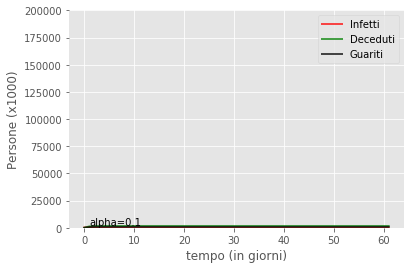

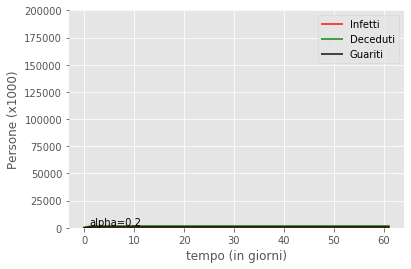

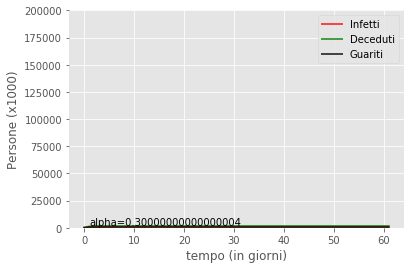

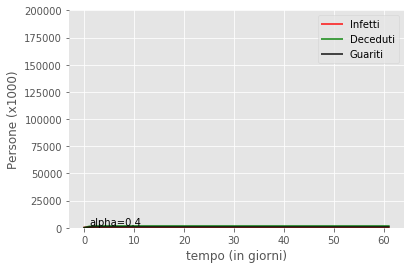

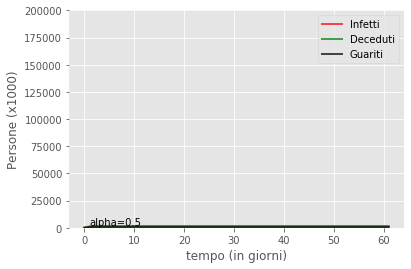

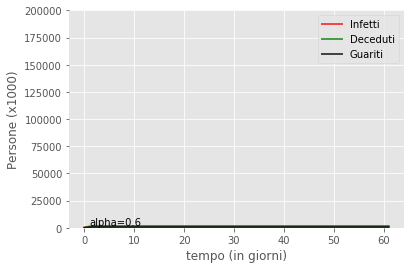

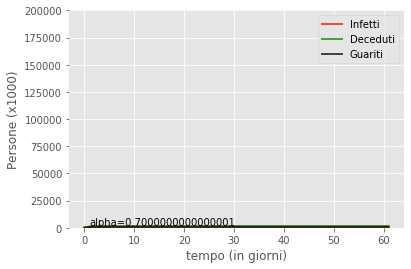

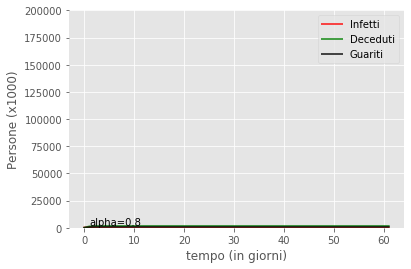

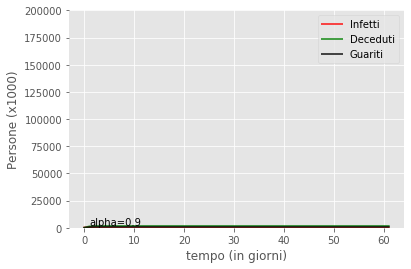

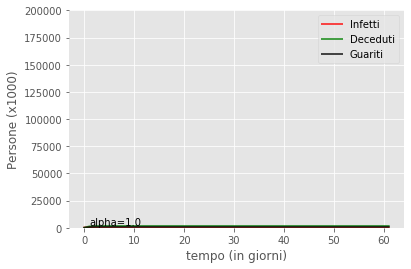

In [111]:
for alpha in np.linspace(0.1,1,10):
    grafico(alpha,prova[1])

In [112]:
prova

([0.4589028036855425, 0.15720582802863795, 0.015255752080024186],
 array([[ 6.03600000e+06,  2.21000000e+02,  7.00000000e+00,
          1.00000000e+00],
        [ 1.01568515e-09,  5.72413986e+02,  1.27760878e+03,
          6.37957998e+02],
        [ 4.81983750e-10,  1.30701764e+02,  1.57182832e+03,
          7.85450677e+02],
        [ 8.25056470e-12,  2.98436993e+01,  1.63900874e+03,
          8.19128319e+02],
        [ 2.79412680e-12,  6.81434105e+00,  1.65434834e+03,
          8.26818080e+02],
        [ 2.19007948e-12,  1.55594804e+00,  1.65785090e+03,
          8.28573917e+02],
        [ 2.07159654e-12,  3.55276366e-01,  1.65865065e+03,
          8.28974835e+02],
        [ 2.04545452e-12,  8.11217979e-02,  1.65883326e+03,
          8.29066378e+02],
        [ 2.03953182e-12,  1.85228943e-02,  1.65887496e+03,
          8.29087280e+02],
        [ 2.03818187e-12,  4.22941337e-03,  1.65888448e+03,
          8.29092053e+02],
        [ 2.03787375e-12,  9.65719249e-04,  1.65888665e+03,
    